# Analyze customer data from Austin, TX. 

In this lab, we will analyze various features of customer energy usage data from the Pecan Street dataset. The dataset we aim to explore is for the month of January 2017 from various customers in Austin, TX.

Distinguish which houses have rooftop photovoltaic (PV) panels and which ones do not. For the houses that do not have PV panels, try to predict how much money they would save, given Austin's retail energy rates.

Given the temperature profile, can you predict which houses have AC?

In [2]:
# Start with customary imports.

import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Understand and parse the dataset

There are two csv files that we will utilize in this lab:
1. 'dataport-metadata.csv': It contains the details of what data is available from each house in the entire Pecan Street dataset.
2. 'July2017.csv': It contains the energy data from houses in Austin for the month of July.

### Parse the metadata file.

Only consider customers from Austin, TX for which electricity usage data is present.


In [3]:
# Load the 'metadata' file that contains information about individual houses into a pandas dataframe.
dfCityCustomers = pd.read_csv("dataport-metadata.csv", index_col=0)

# Only consider the houses that are in Austin and have power consumption data.
dfCityCustomers = dfCityCustomers.loc[(dfCityCustomers['city'] == 'Austin') & (dfCityCustomers['use'] == 'yes')]

# Restrict attention to useful columns.
dfCityCustomers = dfCityCustomers[['date_enrolled', 'date_withdrawn', 
                                   'building_type', 'total_square_footage', 'first_floor_square_footage',
                                   'pv', 'air1', 'air2', 'air3', 'airwindowunit1',
                                   'gen', 'use', 'grid']]

# Replace binary data with zeros and ones.
binaryColumns = ['pv', 'air1', 'air2', 'air3', 'airwindowunit1', 'gen', 'use', 'grid']
for bColumn in binaryColumns:
    dfCityCustomers[bColumn] = dfCityCustomers[bColumn].map({'yes' : 1}).fillna(0)

start_day = datetime.datetime.strptime('2017-07-01', '%Y-%m-%d').date()
    
dfCityCustomers['date_enrolled'] = [datetime.datetime.strptime(x, "%Y-%m-%d") 
                                    for x in dfCityCustomers['date_enrolled']]

dfCityCustomers = dfCityCustomers.loc[(dfCityCustomers['date_enrolled'] <= '2017-07-01')]
print("Parsed the metadata file successfully.")

Parsed the metadata file successfully.


### Parse the energy usage data.

Here, we shall clean the data. 

1. The data downloaded from dataport.cloud has a mislabeled colmn. Correct that.
2. Split the 'localhour' field into two fiels: actual date and an hour of day.
3. Only choose data from households that are 'Single-Family Homes'.
4. Make sure there is data from 31 days.
5. Ensure that the metadata includes the square footage for the entire home and its first floor.

Finally, create a pandas dataframe where indices are house id's.

In [4]:
# Load the data from Jan 2017 from houses in Texas.
dfData = pd.read_csv("July2017.csv")

# Cleanup item 1. Alter the column names because there is an error in the downloaded data. The column names
# 'dataid' and 'localhour' are switched in the .csv file. Correct it. 
# Cleanup item 2. Split the hour and the day in the field 'localhour' and convert the date to an 
# actual datetime object.

dfData.columns = [x.lstrip() for x in dfData.columns]
dfData = dfData[['dataid', 'localhour', 'use', 'grid', 'gen', 'air1', 'air2', 'air3', 'airwindowunit1']]
dfData.columns = ['date', 'dataid', 'use', 'grid', 'gen', 'air1', 'air2', 'air3', 'airwindowunit1']

dfData['hour'] = [datetime.datetime.strptime(x[:-3], "%Y-%m-%d %H:%M:%S").hour for x in dfData['date']]
dfData['date'] = [datetime.datetime.strptime(x[:-3], "%Y-%m-%d %H:%M:%S").date() for x in dfData['date']]

# Create a dataframe where indices are house id's.
dfData_houses = pd.DataFrame(columns=['ac', 'pv', 'area', 'area_floor', 'data'])

for house_id in dfData['dataid'].unique():
    
    # Make sure that each house with consumption data is also in metadata.
    if house_id in dfCityCustomers.index.values:
        dfData_one_house = dfData.loc[dfData['dataid'] == house_id]

        # Cleanup item 3, 4, 5.
        if ((len(dfData_one_house) >= 24 * 31) & 
        (np.sum(dfData_one_house['use'].values) != 0) & 
        (dfCityCustomers.loc[house_id, 'building_type'] == 'Single-Family Home') & 
        (np.isnan(dfCityCustomers.loc[house_id, 'total_square_footage']) == False) & 
        (np.isnan(dfCityCustomers.loc[house_id, 'first_floor_square_footage']) == False)):
            
            # Create a pandas dataframe with house id's as indices and has the following items: 
            # 1. Binary status: "ac", "pv".
            # 2. Total square footrage, and the square footage of the first floor.
            
            is_ac_in_house =  (dfCityCustomers.loc[house_id, 'air1'] 
                               or dfCityCustomers.loc[house_id, 'air2']
                               or dfCityCustomers.loc[house_id, 'air3']
                               or dfCityCustomers.loc[house_id, 'airwindowunit1']
                              )
            
            dfData_houses.loc[house_id] = [is_ac_in_house, 
                                           dfCityCustomers.loc[house_id, 'pv'],
                                           dfCityCustomers.loc[house_id, 'total_square_footage'],
                                           dfCityCustomers.loc[house_id, 'first_floor_square_footage'],
                                           dfData_one_house
                                          ]

# Define a function that retrieves the hourly energy profile from the column in "field" from a
# specific house and day. The day is measured as number of days since the start date of Jan 1, 2017.

def energy_day(house_id, day, field): 
    date_day = start_day + datetime.timedelta(days=day)
    dfData_house = dfData_houses.loc[house_id, 'data']
    return dfData_house.loc[dfData_house['date'] == date_day].sort_values(by=['hour'])[field].values

# Define a function that retrieves the aggregate energy consumed (or produced) as detailed in the column 
# named "field" from a specific house over all days.

def total_energy_all_days(house_id, field): 
    total_energy = 0
    for day in range(31):
        total_energy += np.sum(energy_day(house_id, day, field))
    return total_energy


# Cleanup item 4 continued: Delete data from houses where the date and hour do not perfectly 
# align with the 31 days in July, and hours being from 0 to 23.
house_ids_to_delete = []
for house_id in dfData_houses.index.values:
    for day in range(31):
        if len(energy_day(house_id, day, 'grid')) != 24:
            house_ids_to_delete.append(house_id)
            continue

dfData_houses.drop(house_ids_to_delete, inplace=True)

print("Data loaded and parsed successfully from %d single-family homes." % (len(dfData_houses)))

del dfData , dfCityCustomers           

Data loaded and parsed successfully from 222 single-family homes.


## Distinguish houses with rooftop solar panels from daily energy usage profile.

Take data of energy drawn from the grid for 10 days and do logistic regression.

### Q1. Explain Logistic regression. (10 points)

Logistic Regression is a One Layer Neural Network (with one weight and bias) with an activation function called the sigmoid which maps the result between 0 and 1. If the value of z is negative it will be mapped to 0 and if its positive it will be mapped to 1. 

In [6]:
print("Number of houses with PV panels = %d" % (len(dfData_houses.loc[dfData_houses['pv'] == 1])) )
print("Number of houses without PV panels = %d" % (len(dfData_houses.loc[dfData_houses['pv'] == 0])) )

XX = []
YY = []

days_data = random.sample(range(31), 10)

for house_id in dfData_houses.index.values:
    XX.append(np.ravel([energy_day(house_id, day, 'grid') for day in days_data]))
    YY.append(dfData_houses.loc[house_id, 'pv'])

YY = np.reshape(YY, (-1, 1))

train_X, test_X, train_Y, test_Y = train_test_split(XX, YY, test_size=.2, shuffle=True)

train_X = tf.dtypes.cast(train_X, tf.float32)
test_X = tf.dtypes.cast(test_X, tf.float32)
train_Y = tf.dtypes.cast(train_Y, tf.float32)
test_Y = tf.dtypes.cast(test_Y, tf.float32)

print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)
del XX, YY

Number of houses with PV panels = 146
Number of houses without PV panels = 76
(177, 240)
(45, 240)
(177, 1)
(45, 1)


### Q2. Design the neural network. In the next cell, fill in the missing pieces. (30 points)


In [5]:
n_inputs = np.shape(train_X)[1]
n_outputs = np.shape(train_Y)[1]

weight = tf.Variable(tf.random.truncated_normal(shape = [n_inputs, n_outputs]))
bias = tf.Variable(tf.random.truncated_normal(shape=[n_outputs]))
bce = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

@tf.function
def neuralNetworkModel(X):
    global weight, bias
    model = tf.nn.sigmoid(tf.matmul(X, weight) + bias)
    return model

# Define number of epochs
nEpoch = 1000
trainable_variables = [weight, bias]

# Define the training scheme
def train(model, x_set, y_set):
    for epoch in range(nEpoch):
        # Fit the data and compute the gradients
        with tf.GradientTape() as tape:
            prediction = model(x_set)
            loss = bce(y_true=y_set, y_pred=prediction)
            lossEpoch = loss.numpy()
            print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
            
            # Optimize the weights
            gradients = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))

# Train the model
print ("Start neural network training.")
train(neuralNetworkModel, train_X, train_Y)

test_prediction = tf.math.round(neuralNetworkModel(test_X))
test_accuracy = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(test_Y, test_prediction), tf.float32))
print("Accuracy of logistic regression on test data = %.2f percent." % (test_accuracy * 100))

Start neural network training.
Epoch: 1, Loss: = 10.4
Epoch: 2, Loss: = 10.4
Epoch: 3, Loss: = 10.4
Epoch: 4, Loss: = 10.4
Epoch: 5, Loss: = 10.4
Epoch: 6, Loss: = 10.4
Epoch: 7, Loss: = 10.4
Epoch: 8, Loss: = 10.4
Epoch: 9, Loss: = 10.4
Epoch: 10, Loss: = 10.4
Epoch: 11, Loss: = 10.4
Epoch: 12, Loss: = 10.4
Epoch: 13, Loss: = 10.4
Epoch: 14, Loss: = 10.4
Epoch: 15, Loss: = 10.4
Epoch: 16, Loss: = 10.4
Epoch: 17, Loss: = 10.4
Epoch: 18, Loss: = 10.4
Epoch: 19, Loss: = 10.4
Epoch: 20, Loss: = 10.4
Epoch: 21, Loss: = 10.4
Epoch: 22, Loss: = 10.4
Epoch: 23, Loss: = 10.4
Epoch: 24, Loss: = 10.4
Epoch: 25, Loss: = 10.4
Epoch: 26, Loss: = 10.4
Epoch: 27, Loss: = 10.4
Epoch: 28, Loss: = 10.4
Epoch: 29, Loss: = 10.4
Epoch: 30, Loss: = 10.4
Epoch: 31, Loss: = 10.4
Epoch: 32, Loss: = 10.4
Epoch: 33, Loss: = 10.4
Epoch: 34, Loss: = 10.4
Epoch: 35, Loss: = 10.4
Epoch: 36, Loss: = 10.4
Epoch: 37, Loss: = 10.4
Epoch: 38, Loss: = 10.4
Epoch: 39, Loss: = 10.4
Epoch: 40, Loss: = 10.4
Epoch: 41, Loss: =

Epoch: 352, Loss: = 1.3
Epoch: 353, Loss: = 1.3
Epoch: 354, Loss: = 1.3
Epoch: 355, Loss: = 1.3
Epoch: 356, Loss: = 1.3
Epoch: 357, Loss: = 1.3
Epoch: 358, Loss: = 1.3
Epoch: 359, Loss: = 1.3
Epoch: 360, Loss: = 1.3
Epoch: 361, Loss: = 1.3
Epoch: 362, Loss: = 1.3
Epoch: 363, Loss: = 1.3
Epoch: 364, Loss: = 1.2
Epoch: 365, Loss: = 1.2
Epoch: 366, Loss: = 1.2
Epoch: 367, Loss: = 1.2
Epoch: 368, Loss: = 1.2
Epoch: 369, Loss: = 1.2
Epoch: 370, Loss: = 1.2
Epoch: 371, Loss: = 1.2
Epoch: 372, Loss: = 1.2
Epoch: 373, Loss: = 1.2
Epoch: 374, Loss: = 1.2
Epoch: 375, Loss: = 1.2
Epoch: 376, Loss: = 1.1
Epoch: 377, Loss: = 1.1
Epoch: 378, Loss: = 1.1
Epoch: 379, Loss: = 1.1
Epoch: 380, Loss: = 1.1
Epoch: 381, Loss: = 1.1
Epoch: 382, Loss: = 1.1
Epoch: 383, Loss: = 1.1
Epoch: 384, Loss: = 1.1
Epoch: 385, Loss: = 1.1
Epoch: 386, Loss: = 1.1
Epoch: 387, Loss: = 1.1
Epoch: 388, Loss: = 1.1
Epoch: 389, Loss: = 1.1
Epoch: 390, Loss: = 1.1
Epoch: 391, Loss: = 1.1
Epoch: 392, Loss: = 1.0
Epoch: 393, Loss

Epoch: 718, Loss: = 0.6
Epoch: 719, Loss: = 0.6
Epoch: 720, Loss: = 0.6
Epoch: 721, Loss: = 0.6
Epoch: 722, Loss: = 0.6
Epoch: 723, Loss: = 0.6
Epoch: 724, Loss: = 0.6
Epoch: 725, Loss: = 0.6
Epoch: 726, Loss: = 0.6
Epoch: 727, Loss: = 0.6
Epoch: 728, Loss: = 0.6
Epoch: 729, Loss: = 0.6
Epoch: 730, Loss: = 0.6
Epoch: 731, Loss: = 0.6
Epoch: 732, Loss: = 0.6
Epoch: 733, Loss: = 0.6
Epoch: 734, Loss: = 0.6
Epoch: 735, Loss: = 0.6
Epoch: 736, Loss: = 0.6
Epoch: 737, Loss: = 0.6
Epoch: 738, Loss: = 0.6
Epoch: 739, Loss: = 0.6
Epoch: 740, Loss: = 0.6
Epoch: 741, Loss: = 0.6
Epoch: 742, Loss: = 0.6
Epoch: 743, Loss: = 0.6
Epoch: 744, Loss: = 0.6
Epoch: 745, Loss: = 0.6
Epoch: 746, Loss: = 0.6
Epoch: 747, Loss: = 0.6
Epoch: 748, Loss: = 0.6
Epoch: 749, Loss: = 0.6
Epoch: 750, Loss: = 0.6
Epoch: 751, Loss: = 0.6
Epoch: 752, Loss: = 0.6
Epoch: 753, Loss: = 0.6
Epoch: 754, Loss: = 0.6
Epoch: 755, Loss: = 0.6
Epoch: 756, Loss: = 0.6
Epoch: 757, Loss: = 0.6
Epoch: 758, Loss: = 0.6
Epoch: 759, Loss

### Q3.  Print the classification report on the test data. The function 'classification_report' from 'sklearn.metrics' might prove useful. (10 points)

In [6]:
# Enter code here
print(classification_report(test_Y, test_prediction))

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        20
         1.0       0.84      0.84      0.84        25

    accuracy                           0.82        45
   macro avg       0.82      0.82      0.82        45
weighted avg       0.82      0.82      0.82        45



### Q4. Based on the classification report you obtain, your classifier is better in which of the following tasks? (20 points)
1. If it identifies a house to have a PV panel, then it has a PV panel.
2. If there is a PV panel, then it identifies that it has a PV panel.

Furthermore, complete the code below to plot the energy drawn from the grid from houses with and without PV panels.

Based on my classification report, weighted precision is 0.87 and weighted recall is 0.87 so the classifier is equally good at precision and recall-
- precision is if it identifies a house to have a PV panel, then it has a PV panel
- recall is if there is a PV panel, then it identifies that it has a PV panel.

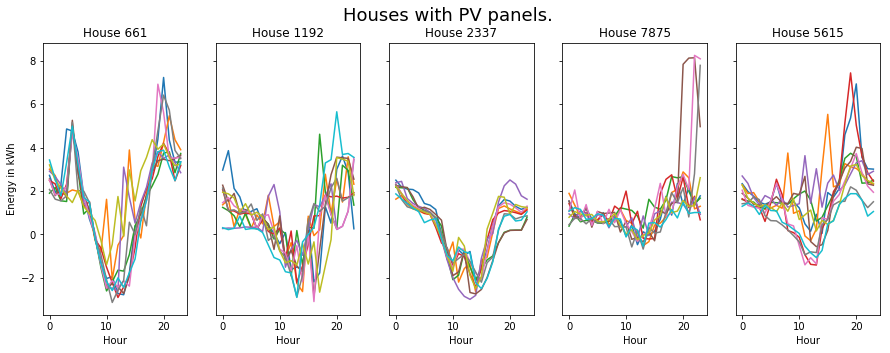

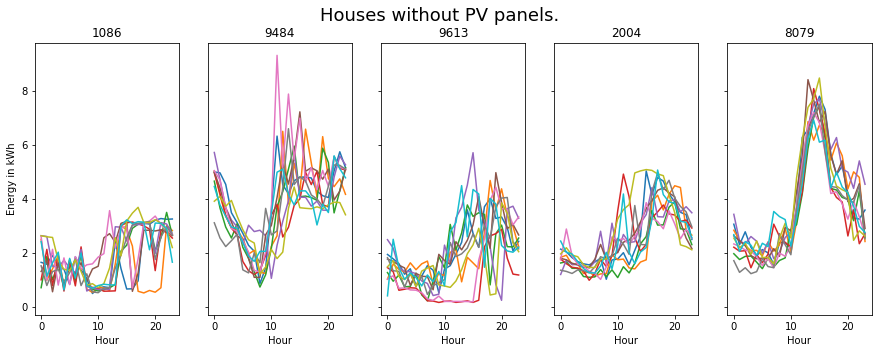

In [7]:
# Plot energy drawn from grid for houses with PV's.
house_id_pv = random.sample(list(dfData_houses.loc[dfData_houses['pv'] == 1].index.values), 5)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15,5))

for tt, house_id in enumerate(house_id_pv):
    for day in days_data:
        axs[tt].plot(energy_day(house_id, day, 'grid'))
    axs[tt].set_title("House " + str(house_id))
fig.suptitle('Houses with PV panels.', fontsize=18)

for ax in axs.flat:
    ax.set(xlabel='Hour', ylabel='Energy in kWh')
for ax in axs.flat:
    ax.label_outer()

house_id_not_pv = random.sample(list(dfData_houses.loc[dfData_houses['pv'] == 0].index.values), 5)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15,5))
axs = axs.ravel()

for tt, house_id in enumerate(house_id_not_pv):
    for day in days_data:
        axs[tt].plot(energy_day(house_id, day, 'grid'))
    axs[tt].set_title(house_id)

fig.suptitle('Houses without PV panels.', fontsize=18)        

for ax in axs.flat:
    ax.set(xlabel='Hour', ylabel='Energy in kWh')
for ax in axs.flat:
    ax.label_outer()

### Q5. Design a classifier to distinguish between houses with and without PV based on the plots. Print your classification report, and compare it with logistic regression. (10 points, bonus) 

In [8]:
# Compare the performance of a neural network based classifier with an educated guess.
nDimX = np.shape(train_X)[1]
nDimY = np.shape(train_Y)[1]
nHidden1 = 45

W1 = tf.Variable(tf.random.truncated_normal(shape = [nDimX, nHidden1]))
b1 = tf.Variable(tf.random.truncated_normal(shape=[nHidden1]))

W2 = tf.Variable(tf.random.truncated_normal(shape=[nHidden1, nDimY]))
b2 = tf.Variable(tf.random.truncated_normal(shape=[nDimY]))

loss_fn = tf.losses.BinaryCrossentropy()
optimizer = tf.optimizers.Adagrad(0.01)


@tf.function
def neuralNetworkModel(X):
    global  W1, b1, W2, b2 
    Z1 = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
    Z1 = tf.nn.dropout(Z1, 0.005)
    Z2 = tf.nn.sigmoid(tf.matmul(Z1, W2) + b2)
    Z2 = tf.nn.dropout(Z2, 0.005)
    model = tf.nn.dropout(Z2, 0.005)

    return model

nEpoch =  400
trainable_variables = [W1, b1, W2, b2]

def train(model, x_set, y_set):
    for epoch in range(nEpoch):
        with tf.GradientTape() as tape:
            prediction = model(x_set)
            loss = loss_fn(y_true=y_set, y_pred=prediction)
            lossEpoch = loss.numpy()
            print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
            gradients = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))

print ("Start neural network training.")
train(neuralNetworkModel, train_X, train_Y)

test_neural_net = tf.math.round(neuralNetworkModel(test_X))
test_accuracy = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(test_Y, test_neural_net), tf.float32))
print("Accuracy of neural net on test data = %.2f percent." % (test_accuracy * 100))

Start neural network training.
Epoch: 1, Loss: = 1.7
Epoch: 2, Loss: = 1.8
Epoch: 3, Loss: = 1.6
Epoch: 4, Loss: = 1.5
Epoch: 5, Loss: = 1.5
Epoch: 6, Loss: = 1.4
Epoch: 7, Loss: = 1.5
Epoch: 8, Loss: = 1.2
Epoch: 9, Loss: = 1.3
Epoch: 10, Loss: = 1.3
Epoch: 11, Loss: = 1.2
Epoch: 12, Loss: = 1.1
Epoch: 13, Loss: = 1.2
Epoch: 14, Loss: = 1.4
Epoch: 15, Loss: = 1.2
Epoch: 16, Loss: = 1.1
Epoch: 17, Loss: = 1.1
Epoch: 18, Loss: = 1.1
Epoch: 19, Loss: = 1.1
Epoch: 20, Loss: = 1.1
Epoch: 21, Loss: = 1.2
Epoch: 22, Loss: = 1.0
Epoch: 23, Loss: = 1.0
Epoch: 24, Loss: = 0.9
Epoch: 25, Loss: = 1.1
Epoch: 26, Loss: = 0.9
Epoch: 27, Loss: = 1.0
Epoch: 28, Loss: = 1.0
Epoch: 29, Loss: = 0.9
Epoch: 30, Loss: = 0.9
Epoch: 31, Loss: = 0.9
Epoch: 32, Loss: = 1.0
Epoch: 33, Loss: = 0.9
Epoch: 34, Loss: = 0.7
Epoch: 35, Loss: = 0.8
Epoch: 36, Loss: = 0.8
Epoch: 37, Loss: = 0.8
Epoch: 38, Loss: = 0.8
Epoch: 39, Loss: = 0.8
Epoch: 40, Loss: = 0.8
Epoch: 41, Loss: = 0.8
Epoch: 42, Loss: = 0.8
Epoch: 43, L

Epoch: 352, Loss: = 0.4
Epoch: 353, Loss: = 0.3
Epoch: 354, Loss: = 0.3
Epoch: 355, Loss: = 0.3
Epoch: 356, Loss: = 0.4
Epoch: 357, Loss: = 0.3
Epoch: 358, Loss: = 0.3
Epoch: 359, Loss: = 0.3
Epoch: 360, Loss: = 0.3
Epoch: 361, Loss: = 0.3
Epoch: 362, Loss: = 0.4
Epoch: 363, Loss: = 0.2
Epoch: 364, Loss: = 0.3
Epoch: 365, Loss: = 0.5
Epoch: 366, Loss: = 0.4
Epoch: 367, Loss: = 0.3
Epoch: 368, Loss: = 0.4
Epoch: 369, Loss: = 0.3
Epoch: 370, Loss: = 0.3
Epoch: 371, Loss: = 0.3
Epoch: 372, Loss: = 0.5
Epoch: 373, Loss: = 0.4
Epoch: 374, Loss: = 0.2
Epoch: 375, Loss: = 0.3
Epoch: 376, Loss: = 0.3
Epoch: 377, Loss: = 0.6
Epoch: 378, Loss: = 0.2
Epoch: 379, Loss: = 0.4
Epoch: 380, Loss: = 0.3
Epoch: 381, Loss: = 0.3
Epoch: 382, Loss: = 0.5
Epoch: 383, Loss: = 0.3
Epoch: 384, Loss: = 0.2
Epoch: 385, Loss: = 0.6
Epoch: 386, Loss: = 0.3
Epoch: 387, Loss: = 0.4
Epoch: 388, Loss: = 0.3
Epoch: 389, Loss: = 0.3
Epoch: 390, Loss: = 0.6
Epoch: 391, Loss: = 0.3
Epoch: 392, Loss: = 0.3
Epoch: 393, Loss

In [9]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=3)
neighbors.fit(train_X, np.ravel(train_Y,order='C'))
test_knn = neighbors.predict(test_X)

In [10]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(train_X, np.ravel(train_Y,order='C'))
test_svc = svc.predict(test_X)

In [11]:
print(classification_report(test_Y, test_neural_net))

              precision    recall  f1-score   support

         0.0       0.65      0.75      0.70        20
         1.0       0.77      0.68      0.72        25

    accuracy                           0.71        45
   macro avg       0.71      0.72      0.71        45
weighted avg       0.72      0.71      0.71        45



In [12]:
print(classification_report(test_Y, test_knn))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        20
         1.0       1.00      0.88      0.94        25

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



In [13]:
print(classification_report(test_Y, test_svc))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88        20
         1.0       0.92      0.88      0.90        25

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45



I used 3 classifiers and here are the results 

| Classifier Used | f1-score | 
| --- | ----------- | 
| Neural Network | 0.76 |
| KNearest Neighbor | 0.83 | 
| Support Vector Machine | 0.89  | 


 Therefore, I choose SVC which has the best F1 Score
 
 and compared with Logistic regression



| Classifier Used | f1-score | 
| --- | ----------- | 
| Logistic Regression |  0.93 | 
| Support Vector Machine | 0.89  | 

Therefore, Logistic Regression is superior. 

Additionally, testing accuracy as well. 



| Classifier Used | Accuracy | 
| --- | ----------- | 
| Logistic Regression |  0.93 | 
| Support Vector Machine | 0.89 |

Therefore, Logistic Regression is superior


## What appliance consumes the most power?

Thermal loads are almost always the appliances that consume the most power. The amount of power they draw also typically grows with the size of the house. In the following, we have two tasks:
1. What percentage of energy consumption is due to an air conditioner?
2. Can you derive a linear relationship between household square footage and power consumption from air conditions in July 2017?

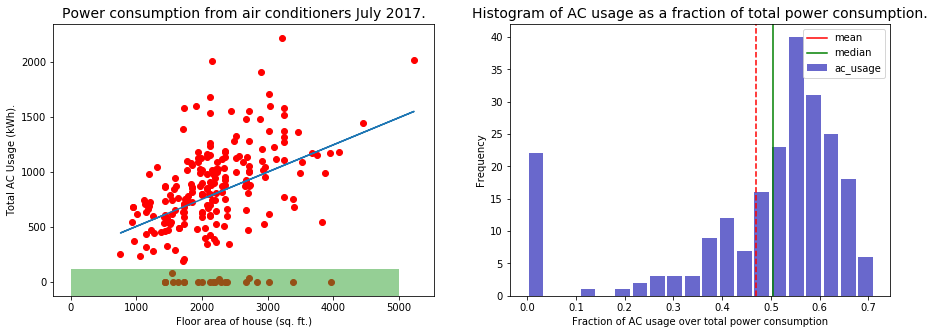

In [14]:
from numpy.polynomial.polynomial import polyfit


for house_id in dfData_houses.index.values:
    dfData_houses.at[house_id, 'ac_usage'] = (total_energy_all_days(house_id, 'air1') + 
                                              total_energy_all_days(house_id, 'air2') + 
                                              total_energy_all_days(house_id, 'air3') +
                                              total_energy_all_days(house_id, 'airwindowunit1')
                                          )
    dfData_houses.at[house_id, 'total_usage'] = total_energy_all_days(house_id, 'use')

fig, axs = plt.subplots(1, 2, figsize=(15,5))

b, m = polyfit(dfData_houses['area'].values, dfData_houses['ac_usage'].values, 1)
axs[0].plot(dfData_houses['area'].values, b + m * dfData_houses['area'].values, '-')
axs[0].scatter(dfData_houses['area'].values, 
               dfData_houses['ac_usage'].values, 
               c='r', marker='o', label='AC usage'
              )
axs[0].set_xlabel('Floor area of house (sq. ft.)')
axs[0].set_ylabel('Total AC Usage (kWh).')
axs[0].set_title('Power consumption from air conditioners July 2017.', fontsize=14)
axs[0].axvspan(0, 5000, ymin=0, ymax=0.1,facecolor='#2ca02c', alpha=0.5)

AC_mean=dfData_houses['ac_usage'].mean()
usage_mean=dfData_houses['total_usage'].mean()
fraction_mean = AC_mean/usage_mean

AC_median=dfData_houses['ac_usage'].median()
usage_median=dfData_houses['total_usage'].median()
fraction_median = AC_median/usage_median

axs[1].axvline(fraction_mean, color='r', linestyle='--')
axs[1].axvline(fraction_median, color='g', linestyle='-')
axs[1].hist(x=np.divide(dfData_houses['ac_usage'], dfData_houses['total_usage']), bins=20, alpha=0.6, color='#0504aa', rwidth=0.85)
axs[1].set_xlabel('Fraction of AC usage over total power consumption')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of AC usage as a fraction of total power consumption.', fontsize=14)
axs[1].plot(fraction_mean, color='r', label='mean')
axs[1].legend(loc="upper right")
axs[1].plot(fraction_median, color='g', label='median')
axs[1].legend(loc="upper right")

### Q6. Based on the above analysis, will you expect the total power consumption from customers to be more or less in October as compared to that in July? How does the above analysis compare to your analysis in Lab 1 on aggregate load prediction in Texas? (10 points)

### Q7. Can you think of a business case for the above histogram? (5 points, bonus)

A6. The total power consumption in October will be less than that of July because the mean and median fraction of AC usage over total power consumption falls roughly between 45-50% in Austin (from the second graph). This agrees with the analysis in Lab 1 where we showed that the total consumption (and aggregade load) had a fall in the cooler months in Texas. 

A7. I can choose houses that have a higher ratio of AC Usage to Floor Area from my dataset. (houses above blue line on the first graph). Chances are that their AC's are not working efficiently. This will allow me to advertise AC repair consultations to those houses. Additionally, a lot of people seem to have their AC's turned off (marked on the graph by green section on first graph). This would mean that they've probably gone on vacation or do not live there. I could advertise a company like AirBnb to them in case they want to rent out their houses.

### Compute monthly electric bills for each customer

Your electricity bill consists of various charges. These charges depend on the utility company you pay your electricity bill to. In Champaign, IL, your distribution utility company is Ameren. In Austin, a major distribution utility company is Austin Energy. Their bill structure is discussed in the following link:
https://austinenergy.com/ae/residential/rates/residential-electric-rates-and-line-items

Calculate the monthly bill of each household.

1. For each customer, compute the total energy consumed, available in the data field "use" over the month. Use the tiered rate structure to compute the total power bill for energy consumption.

2. For customers with PV panels, compute the total energy produced by the PV panels. Assume that Ameren Energy pays 9.7 cents/kWh for such production, and subtract the amount for solar power production from the power bill.

In [15]:
# Define a function that computes the electricity bill according to the structure defined by Austin Energy.

def electricity_bill(consumption):
    customer_charge = 10
    power_supply_adjustment = 2.895 * consumption / 100.0
    community_benefit_charge = (0.154 + 0.124 + 0.335) * consumption / 100.0
    regulatory_charge = 1.342 * consumption / 100.0
    
    tier_rate = [2.801, 5.832, 7.814, 9.314, 10.814]    
    tier_limits = [0, 500, 1000, 1500, 2500, math.inf]
    n_tiers = 5
    
    energy_charge = 0
    
    for tier in range(n_tiers):
        consumption_tier = min(max(consumption, tier_limits[tier]), tier_limits[tier + 1]) - tier_limits[tier]
        energy_charge += consumption_tier * tier_rate[tier] / 100.0
        
    return float('%.2f'%(1.01 * (energy_charge + customer_charge + power_supply_adjustment + community_benefit_charge
                   + regulatory_charge)))

for house_id in dfData_houses.index.values:
    dfData_houses.at[house_id, 'consumption_bill'] = electricity_bill(dfData_houses.loc[house_id, 'total_usage'])
    dfData_houses.at[house_id, 'pv_savings'] = total_energy_all_days(house_id, 'gen') * 9.7 / 100.0
    dfData_houses.at[house_id, 'electricity_bill'] = dfData_houses.loc[house_id, 'consumption_bill'] 
    - dfData_houses.loc[house_id, 'pv_savings']
    
    
print("Electricity bill computed for all customers.")

Electricity bill computed for all customers.


### What is a good indicator of electricity bill for consumption and savings from PV?

Electricity consumption significantly depends on floor area of a house. The dependency is even stronger, if the house is equipped with central AC. A scatter plot of the consumption bill against floor area reveals this dependency.

Monetary savings from PV panels depends on how many PV panels there are, which way they face, and how that relates to solar insolation. The number of panels installed largely depends on the roof area. The floor area of one of the floors is a good indicator. 

In [16]:
dfData_houses.columns

Index(['ac', 'pv', 'area', 'area_floor', 'data', 'ac_usage', 'total_usage',
       'consumption_bill', 'pv_savings', 'electricity_bill'],
      dtype='object')

In [19]:
dfData_houses.describe

<bound method NDFrame.describe of        ac   pv    area  area_floor  \
26    1.0  1.0  2075.0      2075.0   
59    1.0  0.0  3825.0      2705.0   
77    1.0  1.0  2669.0      1455.0   
86    1.0  0.0  1788.0      1788.0   
93    1.0  1.0  2934.0      2934.0   
94    1.0  0.0  1713.0      1713.0   
101   1.0  0.0  1459.0       602.0   
114   1.0  1.0  1842.0      1379.0   
171   0.0  1.0  2376.0      1476.0   
187   1.0  1.0  2122.0      1162.0   
252   0.0  1.0  2669.0      1455.0   
370   1.0  1.0  2680.0      2680.0   
379   1.0  1.0  4080.5      2605.0   
410   1.0  0.0  1152.0      1152.0   
434   1.0  1.0  2158.0      1189.0   
483   1.0  1.0  3249.0      1532.0   
484   1.0  0.0  1592.0      1592.0   
499   1.0  1.0  1709.0      1709.0   
503   1.0  0.0  2486.0      1118.0   
545   1.0  1.0  2345.0      1385.0   
585   0.0  1.0  1720.0      1720.0   
661   1.0  1.0  1842.0      1379.0   
668   1.0  1.0  1972.0      1041.0   
781   1.0  1.0  1946.0      1001.0   
871   1.0  0.0  

So you forgot to change ***area*** to **area floor** for the second graph, so I took the liberty to do that.

Text(0.5,1,'Monthly savings from PV panels over July 2017.')

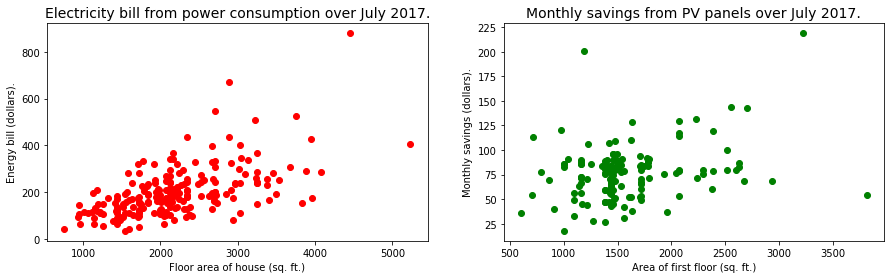

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

# Plot of electricity bill for consumption against the square footage of the house.

axs[0].scatter(dfData_houses['area'].values, 
               dfData_houses['consumption_bill'].values, 
               c='r', marker='o', label='Electricity bill from consumption'
           )
axs[0].set_xlabel('Floor area of house (sq. ft.)')
axs[0].set_ylabel('Energy bill (dollars).')
axs[0].set_title('Electricity bill from power consumption over July 2017.', fontsize=14)

# Plot monetary savings from PV against the area of the first floor.

houses_without_pv = dfData_houses.loc[dfData_houses['pv'] == 0].index.values
houses_with_pv = dfData_houses.loc[dfData_houses['pv'] == 1].index.values

axs[1].scatter(dfData_houses.loc[houses_with_pv, 'area_floor'].values, 
               dfData_houses.loc[houses_with_pv, 'pv_savings'].values, 
               c='g', marker='o', label='Savings from PV')

axs[1].set_xlabel('Area of first floor (sq. ft.)')
axs[1].set_ylabel('Monthly savings (dollars).')
axs[1].set_title('Monthly savings from PV panels over July 2017.', fontsize=14)

### Given the square footage of the house and the first floor, compute the electricity bill with and without PV.
 
Perform a linear regression on electricity bill and monthly savings from PV. Use the linear fits to compute the anticipated electricity bill with and without PV. Report your anticipated percentage savings with PV.

Use the data:
1. Square footage of entire house = 2450 sq. ft.
2. Square footage of first floor = 1380 sq. ft.

### Q8. Fill in the gaps below. Let's say you have $\$18,000$ to spend on a PV and get $\$2,500 $ in solar rebate . How long will it take (in years) for you to recover the initial investment?  (20 points)

In [18]:
area_house = 2450
area_first_floor = 1380

XX = dfData_houses['area'].values.reshape(-1, 1) 
YY = dfData_houses['consumption_bill'].values.reshape(-1, 1)

model_consumption = linear_model.LinearRegression()
model_consumption.fit(XX, YY)

print("Predicted power bill = $%.2f" %  model_consumption.predict(np.array([area_house]).reshape(-1, 1)))

# Enter code here to compute predicted savings from PV
my_XX = dfData_houses.loc[houses_with_pv, 'area_floor'].values.reshape(-1,1)
my_YY = dfData_houses.loc[houses_with_pv, 'pv_savings'].values.reshape(-1,1)
model_savings = linear_model.LinearRegression()
model_savings.fit(my_XX, my_YY)
print("Predicted savings = $%.2f" %  model_savings.predict(np.array([area_first_floor]).reshape(-1, 1)))

del XX, YY

Predicted power bill = $221.84
Predicted savings = $73.91


Initial Cost (Taking rebate into account) = ($\$18,000$ - $\$2500$) = $\$15500$

(Average) Monthly Savings                 =  $\$ 73.91$

Number of Months to Reach Initial Cost    = $\$15500$ / $\$ 73.91$ = 209 Months

209 Months                                =  17 years (approx)